In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Optimizer tweaks

In [2]:
#export
from exp.nb_08 import *

## Imagenette data

In [3]:
path = untar_data(imagenette_160)

In [4]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 128

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler)
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [5]:
nfs = [32, 64, 128, 256]

In [6]:
cbfs = [partial(AvgStatsCallback, accuracy), CudaCallback,
       partial(BatchTransformXCallback, norm_imagenette)]

In [7]:
import gc
learn = None
gc.collect();

In [8]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [9]:
run.fit(1, learn)

train: [1.723199744067008, tensor(0.4093, device='cuda:0')]
valid: [1.650792236328125, tensor(0.4200, device='cuda:0')]


In [10]:
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list):
            self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]
        self.steppers = listify(steppers)
        
    def grad_params(self):
        return [(p, hyper) for pg, hyper in zip(self.param_groups, self.hypers)
               for p in pg if p.grad is not None]
    
    def zero_grad(self):
        for p, hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()
            
    def step(self):
        for p, hyper in self.grad_params():
            compose(p, self.steppers, **hyper)

In [11]:
#export
def sgd_step(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data)
    return p

In [12]:
opt_func = partial(Optimizer, steppers=[sgd_step])

In [13]:
#export
class Recorder(Callback):
    def begin_fit(self):
        self.lrs, self.losses = [], []
        
    def after_batch(self):
        if not self.in_train:
            return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr(self):
        plt.plot(self.lrs)
    
    def plot_loss(self):
        plt.plot(self.losses)
        
    def plot(self, skip_last=0):
        losses = [o.item() for o in self.losses]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])
        
class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_funcs):
        self.pname, self.sched_funcs = pname, listify(sched_funcs)
    
    def begin_batch(self):
        if not self.in_train:
            return
        fs = self.sched_funcs
        if len(fs)==1:
            fs = fs*len(self.opt.param_groups)
        pos = self.n_epochs/self.epochs
        for f,h in zip(fs, self.opt.hypers):
            h[self.pname] = f(pos)

In [14]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

In [15]:
cbfs = [partial(AvgStatsCallback, accuracy),
       CudaCallback, Recorder,
       partial(ParamScheduler, 'lr', sched)]

In [16]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=opt_func)

In [17]:
%time run.fit(1, learn)

train: [1.7631142937121917, tensor(0.3975, device='cuda:0')]
valid: [1.41864599609375, tensor(0.5140, device='cuda:0')]
CPU times: user 8.29 s, sys: 3.61 s, total: 11.9 s
Wall time: 13.1 s


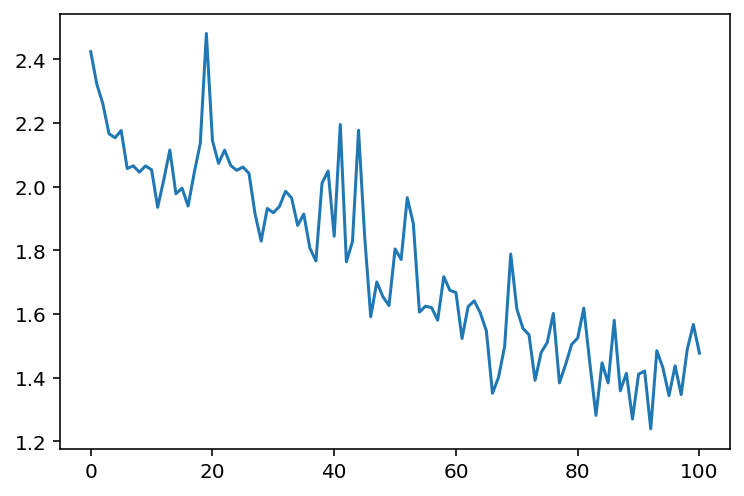

In [18]:
run.recorder.plot_loss()

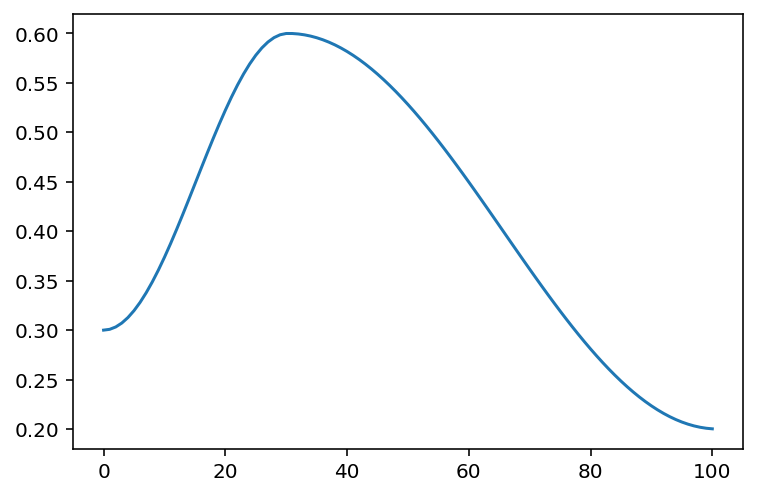

In [19]:
run.recorder.plot_lr()

## Weight decay

In [20]:
#export
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1 - lr*wd)
    return p
weight_decay._defaults = dict(wd=0.)

In [21]:
#export
def l2_reg(p, lr, wd, **kwargs):
    p.grad.data.add_(wd, p.data)
    return p
l2_reg._defaults = dict(wd=0.)

In [22]:
#export
def maybe_update(os, dest, f):
    for o in os:
        for k,v in f(o).items():
            if k not in dest:
                dest[k] = v
                
def get_defaults(d):
    return getattr(d, '_defaults', {})

In [23]:
#export
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)
        maybe_update(self.steppers, defaults, get_defaults)
        self.param_groups = list(params)
        if not isinstance(self.param_groups[0], list):
            self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]
        
    def grad_params(self):
        return [(p, hyper) for pg, hyper in zip(self.param_groups, self.hypers)
               for p in pg if p.grad is not None]
    
    def zero_grad(self):
        for p, hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()
            
    def step(self):
        for p, hyper in self.grad_params():
            compose(p, self.steppers, **hyper)

In [24]:
#export
sgd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step])

In [25]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=sgd_opt)

In [26]:
model = learn.model

In [27]:
opt = sgd_opt(model.parameters(), lr=0.1)
test_eq(opt.hypers[0]['wd'], 0.)
test_eq(opt.hypers[0]['lr'], 0.1)

In [28]:
opt = sgd_opt(model.parameters(), lr=0.1, wd=1e-4)
test_eq(opt.hypers[0]['wd'], 1e-4)
test_eq(opt.hypers[0]['lr'], 0.1)

In [29]:
cbfs = [partial(AvgStatsCallback, accuracy), CudaCallback]

In [30]:
learn, run = get_learn_run(nfs, data, 0.3, conv_layer, cbs=cbfs, opt_func=partial(sgd_opt, wd=0.01))

In [31]:
run.fit(1, learn)

train: [1.699854644117419, tensor(0.4147, device='cuda:0')]
valid: [1.47306103515625, tensor(0.4760, device='cuda:0')]


In [32]:
#export
class StatefulOptimizer(Optimizer):
    def __init__(self, params, steppers, stats=None, **defaults):
        self.stats = listify(stats)
        maybe_update(self.stats, defaults, get_defaults)
        super().__init__(params, steppers, **defaults)
        self.state = {}
        
    def step(self):
        for p, hyper in self.grad_params():
            if p not in self.state:
                self.state[p] = {}
                maybe_update(self.stats, self.state[p], lambda o: o.init_state(p))
            state = self.state[p]
            for stat in self.stats:
                state = stat.update(p, state, **hyper)
            compose(p, self.steppers, **state, **hyper)
            self.state[p] = state

In [33]:
#export
class Stat():
    _defaults = {}
    def init_state(self, p):
        raise NotImplementedError
    def update(self, p, state, **kwargs):
        raise NotImplementedError

In [34]:
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)
    
    def init_state(self, p):
        return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['grad_avg'].mul_(mom).add_(p.grad.data)
        return state

In [35]:
#export
def momentum_step(p, lr, grad_avg, **kwargs):
    p.data.add_(-lr, grad_avg)
    return p

In [36]:
sgd_mom_opt = partial(StatefulOptimizer, steppers=[momentum_step, weight_decay],
                     stats=AverageGrad(), wd=0.01)

In [37]:
learn, run = get_learn_run(nfs, data, 0.3, conv_layer, cbs=cbfs, opt_func=sgd_mom_opt)

In [38]:
run.fit(1, learn)

train: [1.8394185582926168, tensor(0.3892, device='cuda:0')]
valid: [1.7554918212890624, tensor(0.4340, device='cuda:0')]


## Momentum experiments

In [39]:
x = torch.linspace(-4, 4, 200)
y = torch.randn(200) + 0.3
betas = [0.5, 0.7, 0.9, 0.99]

In [40]:
def plot_mom(f):
    _, axs = plt.subplots(2, 2, figsize=(12,8))
    for beta, ax in zip(betas, axs.flatten()):
        ax.plot(y, linestyle='None', marker='.')
        avg, res = None, []
        for i, yi in enumerate(y):
            avg, p = f(avg, beta, yi, i)
            res.append(p)
        ax.plot(res, color='red')
        ax.set_title(f'beta={beta}')

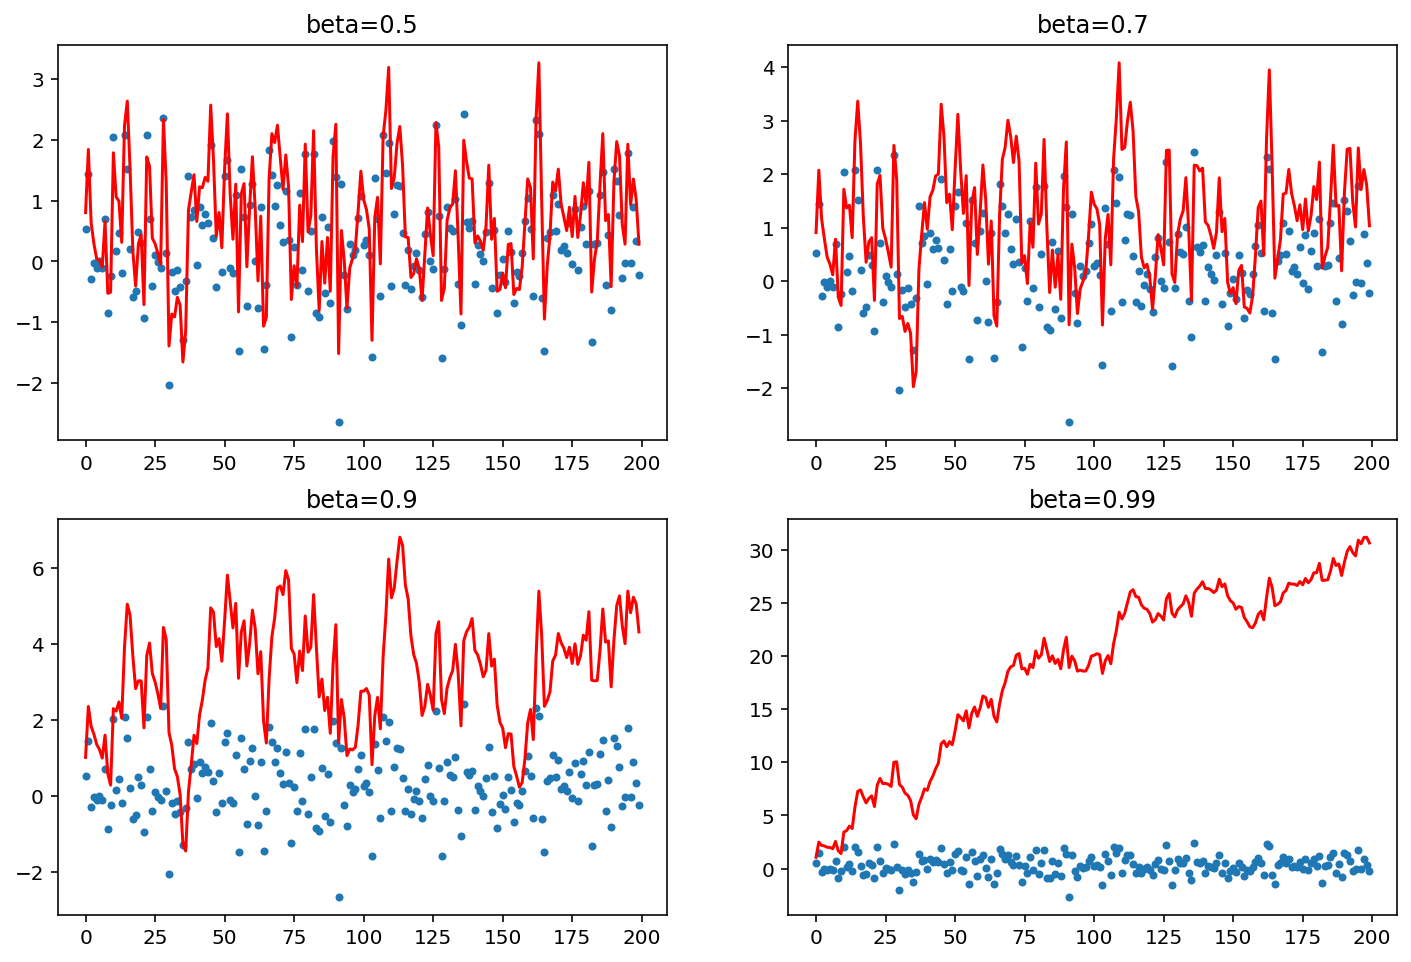

In [41]:
def mom1(avg, beta, yi, i):
    if avg is None:
        avg = yi
    res = beta*avg + yi
    return res, res
plot_mom(mom1)

In [42]:
#export
def lin_comb(v1, v2, beta):
    return beta*v1 + (1-beta)*v2

In [43]:
def ewma(v1, v2, beta):
    return beta*v1 + (1-beta)*v2

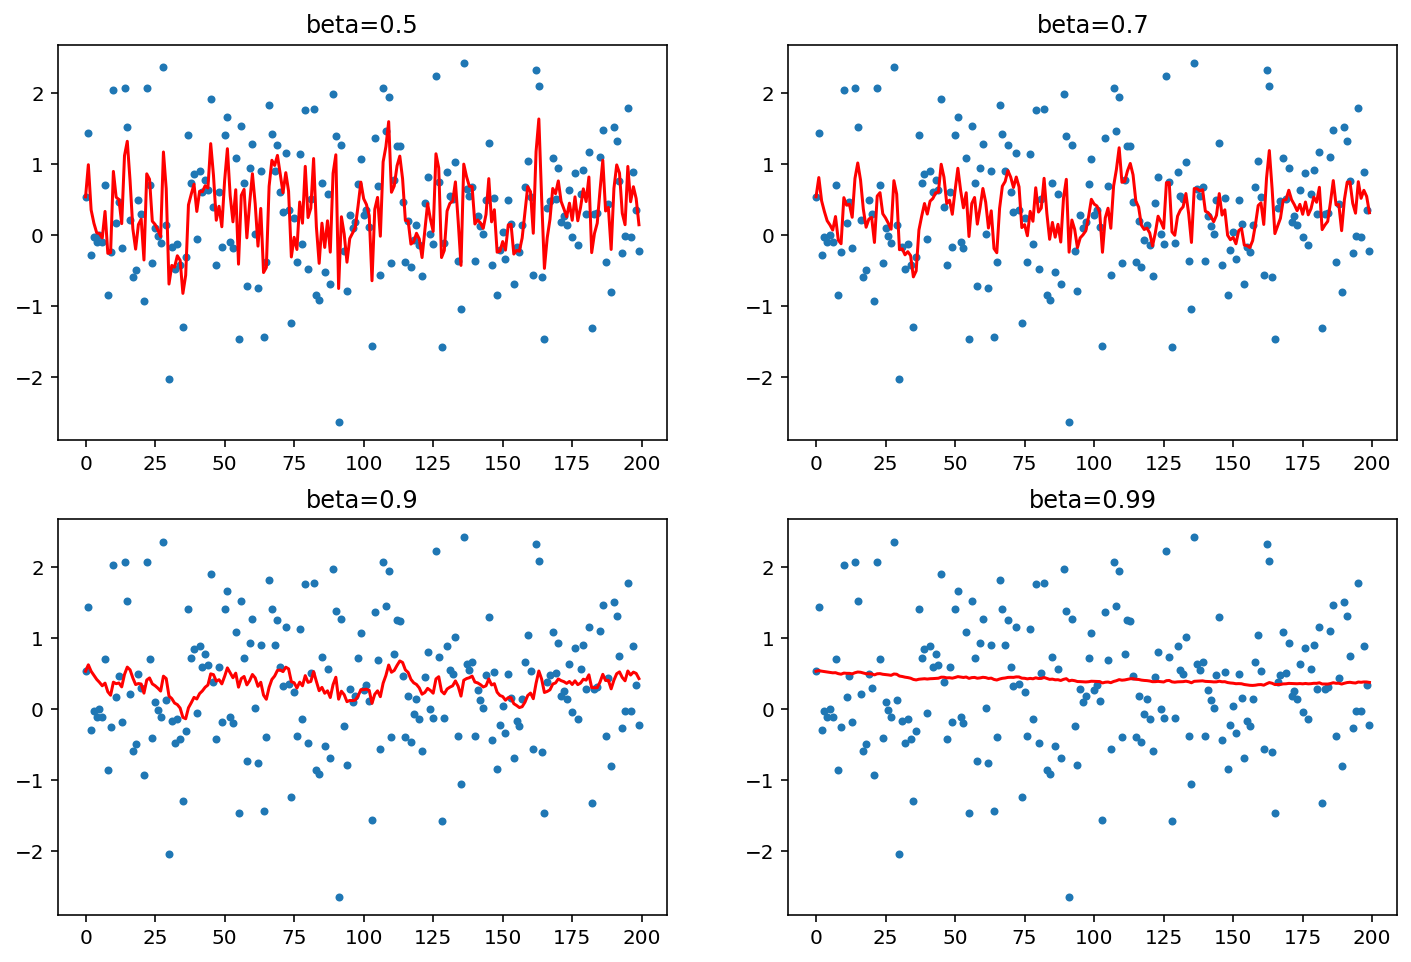

In [44]:
def mom2(avg, beta, yi, i):
    if avg is None:
        avg=yi
    avg = ewma(avg, yi, beta)
    return avg, avg
plot_mom(mom2)

In [45]:
y = 1 - (x/3) ** 2 + torch.randn(200) * 0.1

In [46]:
y[0] = -0.5

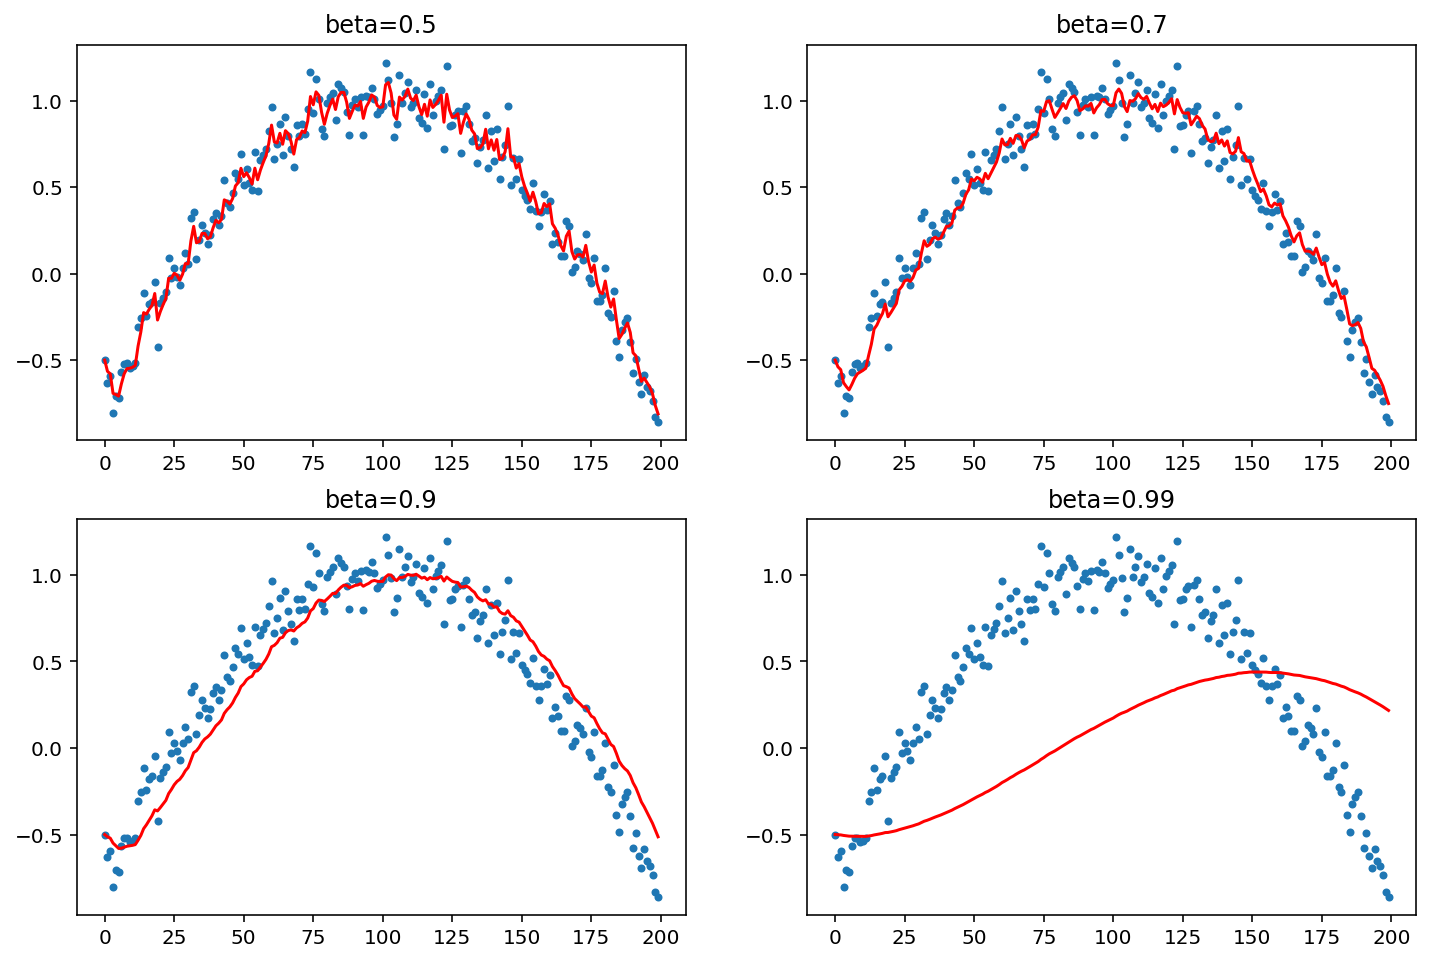

In [47]:
plot_mom(mom2)

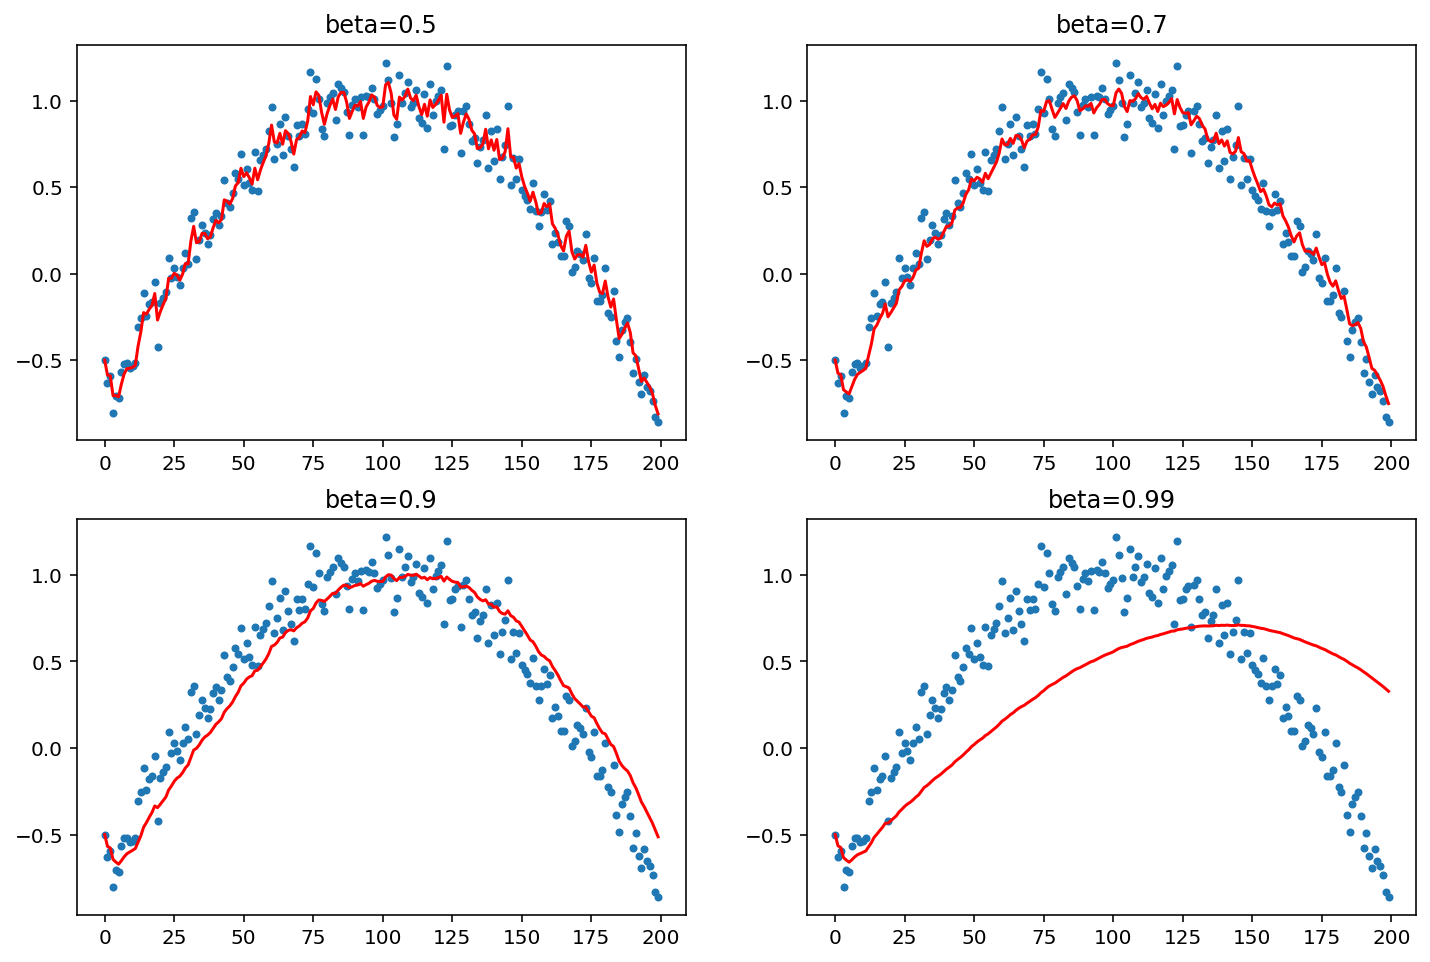

In [48]:
def mom3(avg, beta, yi, i):
    if avg is None:
        avg=0
    avg = ewma(avg, yi, beta)
    return avg, avg/(1-beta**(i+1))
plot_mom(mom3)

# Adam and friends

In [49]:
#export
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)
    
    def __init__(self, dampening:bool=False):
        self.dampening=dampening
    def init_state(self, p):
        return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['mom_damp'] = 1-mom if self.dampening else 1.
        state['grad_avg'].mul_(mom).add_(state['mom_damp'], p.grad.data)
        return state

In [50]:
#export
class AverageSqrGrad(Stat):
    _defaults = dict(sqr_mom=0.99)
    
    def __init__(self, dampening:bool=True):
        self.dampening = dampening
    def init_state(self, p):
        return {'sqr_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, sqr_mom, **kwargs):
        state['sqr_damp'] = 1-sqr_mom if self.dampening else 1.
        state['sqr_avg'].mul_(sqr_mom).addcmul_(state['sqr_damp'], p.grad.data, p.grad.data)
        return state

In [51]:
#export
class StepCount(Stat):
    def init_state(self, p):
        return {'step':0}
    def update(self, p, state, **kwargs):
        state['step'] += 1
        return state

In [52]:
#export
def debias(mom, damp, step):
    return damp * (1 - mom**step) / (1-mom)

In [53]:
#export
def adam_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, **kwargs):
    debias1 = debias(mom, mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    p.data.addcdiv_(-lr/debias1, grad_avg, (sqr_avg/debias2).sqrt() + eps)
    return p

adam_step._defaults = dict(eps=1e-5)

In [54]:
#export
adam_opt = partial(StatefulOptimizer, steppers=adam_step, stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()])

In [55]:
learn, run = get_learn_run(nfs, data, 0.001, conv_layer, cbs=cbfs, opt_func=adam_opt)

In [56]:
run.fit(3, learn)

train: [1.6314586120482395, tensor(0.4398, device='cuda:0')]
valid: [1.252157958984375, tensor(0.5660, device='cuda:0')]
train: [1.0867575883162712, tensor(0.6462, device='cuda:0')]
valid: [1.0587615966796875, tensor(0.6500, device='cuda:0')]
train: [0.8070914918033582, tensor(0.7424, device='cuda:0')]
valid: [0.9598757934570312, tensor(0.6860, device='cuda:0')]


## LAMB optimizer

In [57]:
def lamb_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, wd, **kwargs):
    debias1 = debias(mom, mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    r1 = p.data.pow(2).mean().sqrt()
    step = (grad_avg/debias1) / ((sqr_avg/debias2).sqrt()+eps) + wd*p.data
    r2 = step.pow(2).mean().sqrt()
    p.data.add_(-lr * min(r1/r2, 10), step)
    return p
lamb_step._defaults = dict(eps=1e-6, wd=0.)

In [58]:
lamb = partial(StatefulOptimizer, steppers=lamb_step, stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()])

In [59]:
learn, run = get_learn_run(nfs, data, 0.003, conv_layer, cbs=cbfs, opt_func=lamb)

In [60]:
run.fit(3, learn)

train: [1.8054321535210176, tensor(0.3716, device='cuda:0')]
valid: [1.6963245849609374, tensor(0.4640, device='cuda:0')]
train: [1.2628380024139134, tensor(0.5840, device='cuda:0')]
valid: [1.7595877685546875, tensor(0.4680, device='cuda:0')]
train: [0.9773023820430045, tensor(0.6857, device='cuda:0')]
valid: [1.120859130859375, tensor(0.6180, device='cuda:0')]


# Export

In [61]:
#export
sgd_mom_opt = partial(StatefulOptimizer, steppers=[momentum_step, weight_decay],
                     stats=AverageGrad(), wd=0.01)

In [62]:
!python notebook2script.py 09_optimizers.ipynb

converted 09_optimizers.ipynb to nb_09.py
